In [5]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

In [6]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [7]:
URL = r"https://www.dropbox.com/s/qa1hsyxt66pvj02/opencv_bootcamp_assets_NB10.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB10.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

### Basic Idea
- The dynamic range of images is limited to 8-bits (0 - 255) per channel
- Very bright pixels saturate to 255
- Very dark pixels clip to 0

### Step 1 : Capture Multiple Exposures
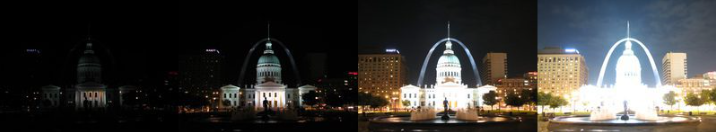

Exposure time (a.k.a. shutter time) is how long the sensor collects light (in seconds).

Short time (e.g., 1/30 ≈ 0.033 s): protects highlights, shadows go dark.

Long time (0.25 s, 2.5 s, 15 s): lifts shadows, but bright areas may blow out.

Bracketing = shoot the same scene at several exposure times. Each photo captures a different part of the scene’s brightness without clipping.

In [9]:
def readImagesAndTimes():
    # List of file names
    filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]

    # List of exposure times
    times = np.array([1 / 30.0, 0.25, 2.5, 15.0], dtype=np.float32)

    # Read images  
    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        images.append(im)

    return images, times

### Step 2: Align Images

MTB = Median Threshold Bitmap (Debevec & Malik trick).

Idea: convert each image to a simple bright/dark bitmap around its median brightness, so alignment is robust to exposure differences.

Then it searches for the best integer shift to stack images on top of each other.

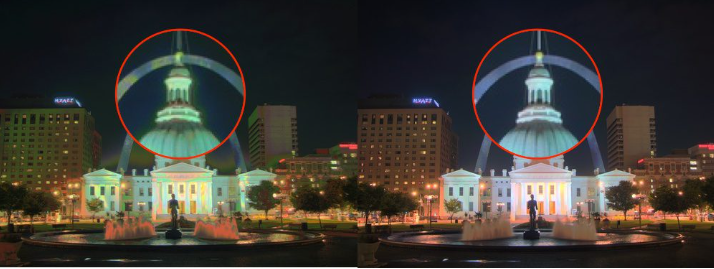

In [10]:
images, times = readImagesAndTimes()

alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

### Step 3: Estimate Camera Response Function

Cameras don’t map scene light → pixel value linearly. They apply a nonlinear curve (gamma, tone curve).
To combine exposures correctly, we estimate that curve.

cv2.createCalibrateDebevec()

Implements Debevec & Malik (1997).

Inputs: the aligned LDR images and their exposure times.

Output: the response curve for each channel (B, G, R) → essentially a function that maps pixel value (0–255) → log irradiance (scene light).

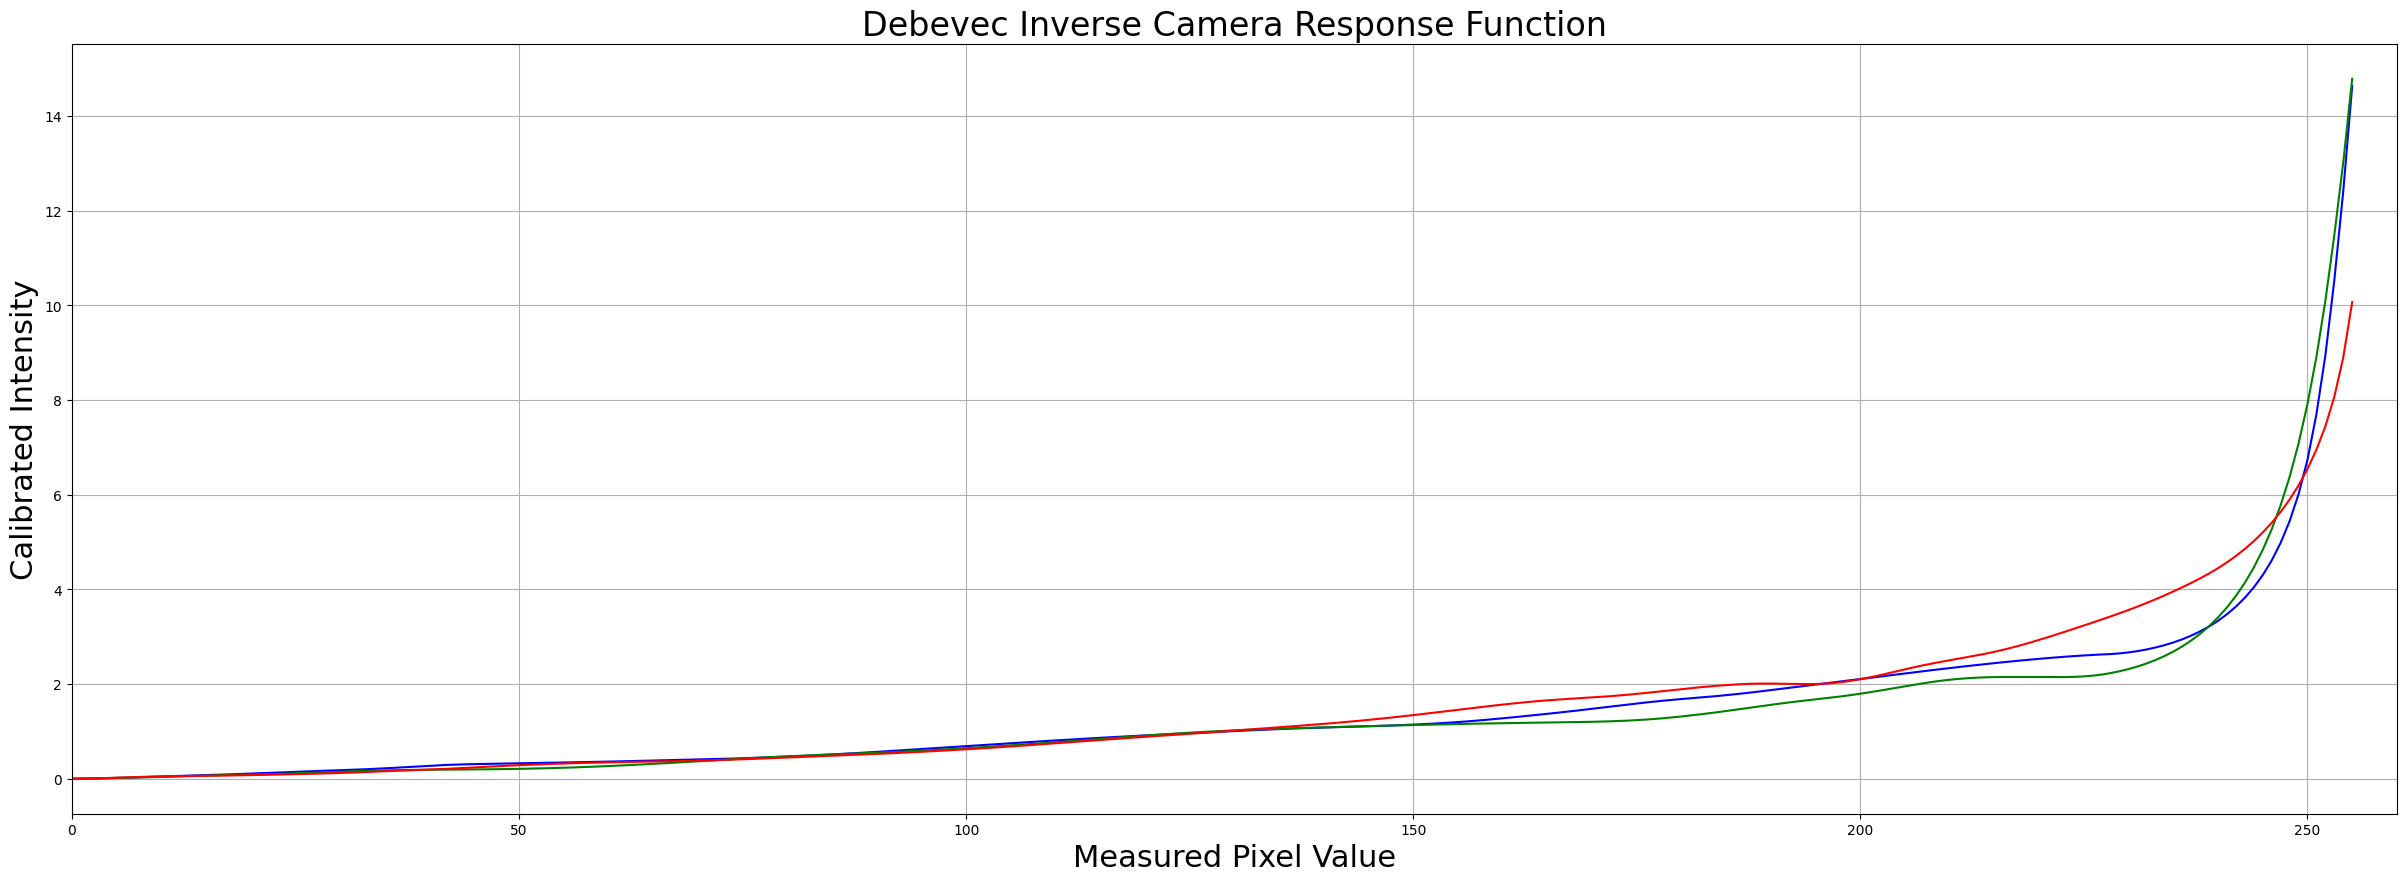

In [17]:
# Find Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:, 0], "b", x, y[:, 1], "g", x, y[:, 2], "r")
plt.show()

### Step 4: Merge Exposure into an HDR Image

Now that we know how to convert pixel values back to scene light, we can combine the stack into a floating-point HDR image.

cv2.createMergeDebevec()

Produces a 32-bit float HDR image (radiance map), typically in linear scene units.

In [13]:
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

### Step 5: Tonemapping
Many Tonemapping algorithms are available in OpenCV. We chose Drago as it has more controls.

5) Tone mapping (compress HDR → displayable LDR)

Tone mapping squashes that huge dynamic range into 0..1 (or 0..255) so it looks good on a regular screen. OpenCV offers several operators; each has a different “look.”

(a) Drago — cv2.createTonemapDrago(gamma, saturation[, bias])

Good for preserving details in bright areas; human-vision inspired.

Typical:

tonemap = cv2.createTonemapDrago(gamma=1.0, saturation=0.7)  # bias uses default (0.85)
ldr = tonemap.process(hdr)    # float32 in [0,1] (usually)


Why multiply by 3?
Tone mapping often returns a result that’s a bit dark; people sometimes scale:

ldr = np.clip(ldr * 3.0, 0, 1)   # brighten before saving


This is just artistic/exposure adjustment, not a requirement.

Why multiply by 255 when saving?
cv2.imwrite for PNG/JPG expects 8-bit. Convert:

out8 = np.clip(ldr * 255, 0, 255).astype(np.uint8)
cv2.imwrite("hdr_drago.png", out8)


That makes a 24-bit color image again (8 bits per channel × 3).

(b) Reinhard — cv2.createTonemapReinhard(gamma, intensity, light_adapt, color_adapt)

A classic “natural” look, nice global+local adaptation.

Example:

tonemap = cv2.createTonemapReinhard(gamma=1.0, intensity=0.0,
                                    light_adapt=1.0, color_adapt=0.0)
ldr = tonemap.process(hdr)
cv2.imwrite("hdr_reinhard.png", (np.clip(ldr,0,1)*255).astype(np.uint8))

(c) Mantiuk — cv2.createTonemapMantiuk(gamma, scale, saturation)

Enhances local contrast / details; can look “HDR-ish” (crunchy).

Example:

tonemap = cv2.createTonemapMantiuk(gamma=1.0, scale=0.7, saturation=1.0)
ldr = tonemap.process(hdr)
cv2.imwrite("hdr_mantiuk.png", (np.clip(ldr,0,1)*255).astype(np.uint8))


All three produce an LDR result (float in 0..1). You can tweak parameters until it looks right, then convert to 8-bit for saving.

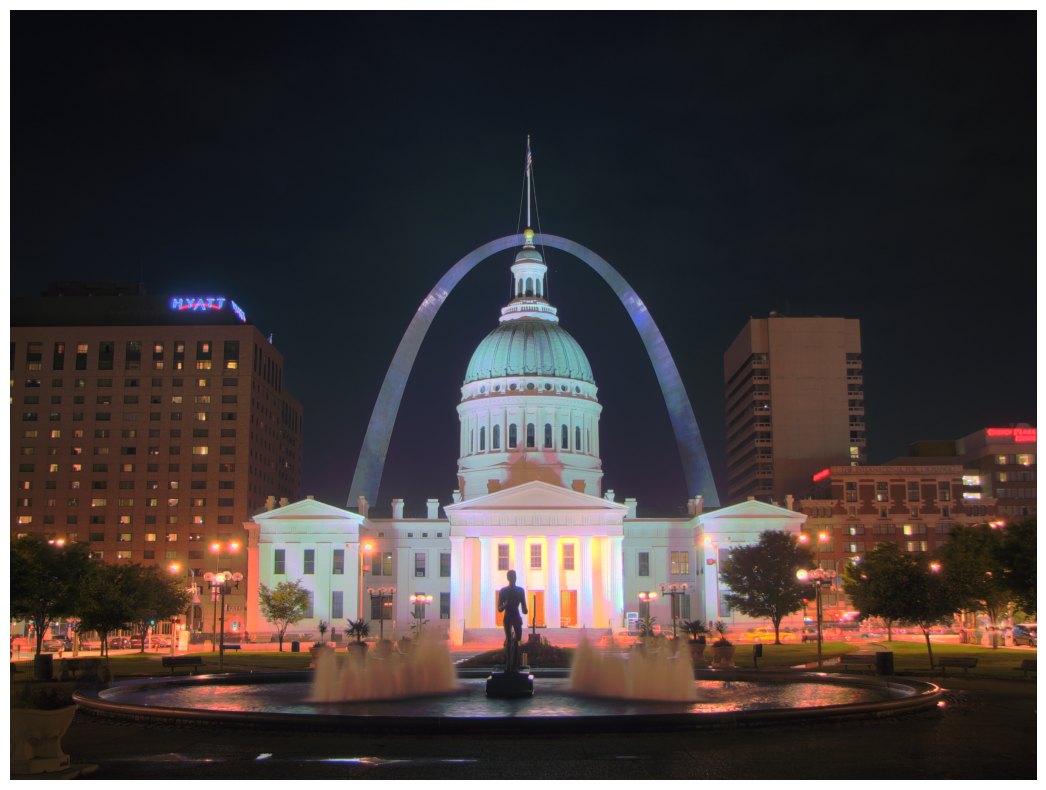

In [14]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago

# Saving image
cv2.imwrite("ldr-Drago.jpg", 255*ldrDrago)

# Plotting image
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrDrago, 0, 1)[:,:,::-1]);plt.axis('off');plt.show()

Tonemaping using Reinhard's method ... 


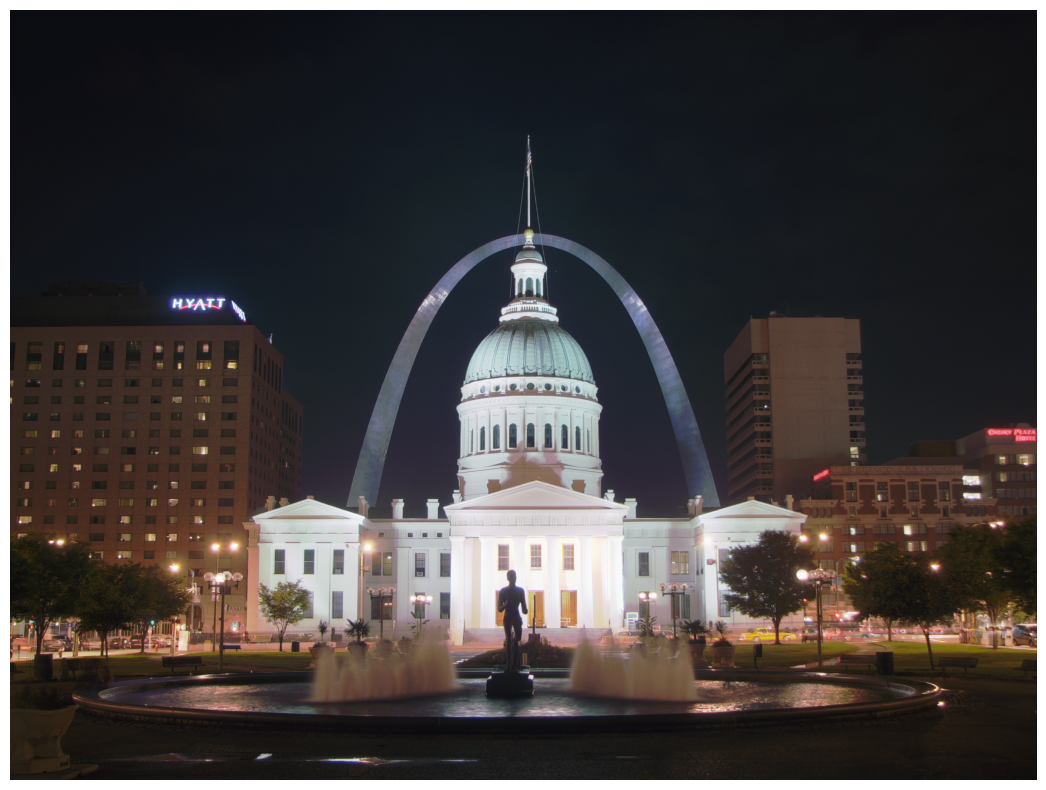

In [15]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0, 0, 0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)

# Saving image
cv2.imwrite("ldr-Reinhard.jpg", ldrReinhard * 255)

# Plotting image
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrReinhard, 0, 1)[:,:,::-1]);plt.axis("off")
plt.show()


Tonemaping using Mantiuk's method ... 


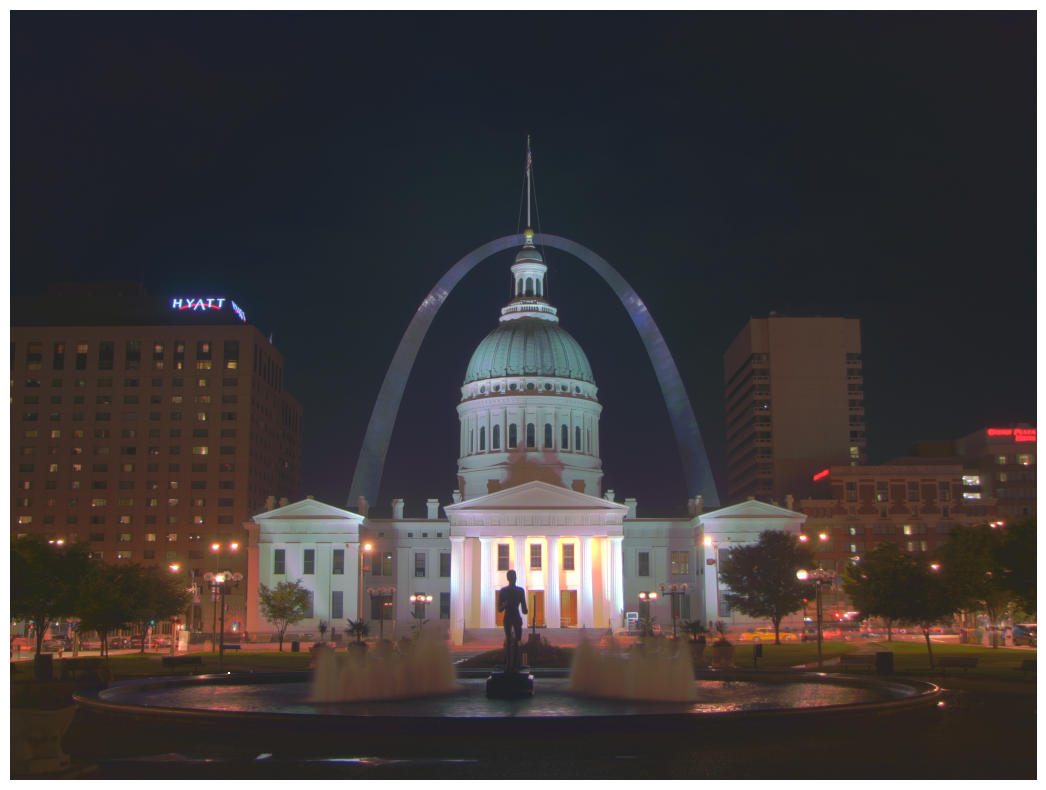

In [16]:
# Tonemap using Mantiuk's method to obtain 24-bit color image
print("Tonemaping using Mantiuk's method ... ")
tonemapMantiuk = cv2.createTonemapMantiuk(2.2, 0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk

# save the image using cv2.imwrite
cv2.imwrite("ldr-Mantiuk.jpg", ldrMantiuk * 255)

# plot the image using plt.imshow
plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrMantiuk, 0, 1)[:,:,::-1]);plt.axis("off")
plt.show()